In [ ]:
# Libraries
# ==============================================================================
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from skforecast.datasets import fetch_dataset
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import TimeSeriesFold, backtesting_sarimax, grid_search_sarimax
from skforecast.plot import set_dark_theme
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

In [454]:
news_df = pd.read_csv('data_collection/data/news/tsv/AMZN.tsv', sep='\t')
trades_df = pd.read_csv('data_collection/data/trades/tsv/AMZN.tsv', sep='\t')

data = trades_df
# Add sentiment counts to data
sentiment_counts = news_df.groupby(news_df['published_utc'].str[:10])['sentiment'].value_counts().unstack(fill_value=0)
sentiment_counts = sentiment_counts.rename(columns={'positive': 'positive', 'neutral': 'neutral', 'negative': 'negative'})

# Merge sentiment counts with data
data = data.merge(sentiment_counts, left_on=data['date'].str[:10], right_index=True, how='left')
data[['positive', 'neutral', 'negative']] = data[['positive', 'neutral', 'negative']].fillna(0).astype(int)
# data.drop('volume', axis=1, inplace=True)
# data.drop('trades', axis=1, inplace=True)
data

,key_0,ticker,date,open,high,low,close,volume,volume_weighted,trades,bearish,bullish,hold,negative,neutral,positive
0,2024-07-01,AMZN,2024-07-01,193.490,198.2957,192.8200,197.20,41192011.0,196.1129,501335,NaN,NaN,NaN,0,0,0
1,2024-07-02,AMZN,2024-07-02,197.280,200.4300,195.9300,200.00,45586383.0,198.7856,485434,0.0,0.0,0.0,0,0,5
2,2024-07-03,AMZN,2024-07-03,199.940,200.0290,196.7601,197.59,30585326.0,198.0469,395363,1.0,0.0,0.0,2,6,15
3,2024-07-05,AMZN,2024-07-05,198.650,200.5500,198.1700,200.00,38858685.0,199.8660,451243,0.0,0.0,0.0,3,7,11
4,2024-07-08,AMZN,2024-07-08,200.040,201.2000,197.9600,199.29,34756586.0,199.4209,443698,0.0,1.0,0.0,1,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,2025-04-22,AMZN,2025-04-22,169.845,176.7800,169.3500,173.18,56607202.0,173.2470,617509,0.0,0.0,0.0,0,2,9
203,2025-04-23,AMZN,2025-04-23,183.450,187.3800,180.1900,180.60,63470094.0,183.1208,732655,0.0,0.0,0.0,1,0,5
204,2025-04-24,AMZN,2025-04-24,180.915,186.7400,180.1800,186.54,43051696.0,184.8668,516091,0.0,0.0,0.0,0,3,3
205,2025-04-25,AMZN,2025-04-25,187.620,189.9400,185.4900,188.99,36413330.0,187.9962,489569,0.0,0.0,0.0,1,5,3


Train dates : 0 --- 157  (n=158)
Test dates  : 157 --- 206  (n=50)


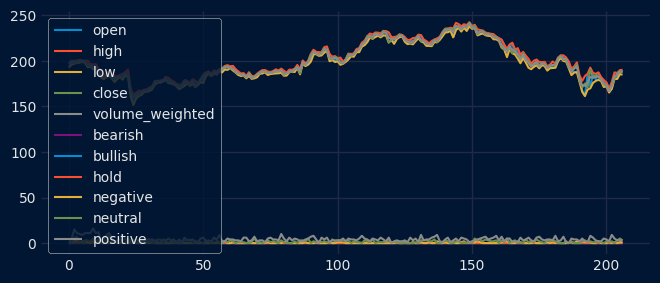

In [455]:

# Train-test dates
# ==============================================================================
# This is day 2024-11-24. Don't ask me
# No longer lel
end_train = 157
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)

# Drop volume and trades for now
data_train = data.loc[:end_train].drop(columns=['volume', 'trades'])
data_test = data.loc[end_train:].drop(columns=['volume', 'trades'])

# Plot
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(7, 3))
data.drop(columns=['volume', 'trades']).plot(ax=ax)
ax.legend();

In [456]:
arima = Sarimax(order=(1, 1, 1))
arima.fit(y=data_train['close'])
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                  158
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -428.150
Date:                Tue, 29 Apr 2025   AIC                            862.301
Time:                        23:18:17   BIC                            871.470
Sample:                             0   HQIC                           866.025
                                - 158                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0898      3.887      0.023      0.982      -7.529       7.709
ma.L1         -0.1118      3.897     -0.029      0.977      -7.751       7.527
sigma2        13.6845      1.136     12.044      0.000      11.457      15.911
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                46.14
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.65
Prob(H) (two-sided):                  0.69   Kurtosis:                         5.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [457]:
# Prediction
# ==============================================================================
predictions = arima.predict(steps=12)
predictions.head(4)

,pred
158,228.714742
159,228.717862
160,228.718142
161,228.718167


In [458]:
# Create and fit ForecasterSarimax
# ==============================================================================
# q was 44
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(2, 4, 4), seasonal_order=(0, 0, 0, 0), maxiter=200),
             )

forecaster.fit(y=data_train['close'], suppress_warnings=True)
forecaster

================= 
ForecasterSarimax 
================= 
Regressor: Sarimax(2,4,4)(0,0,0)[0] 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Training range: [0, 157] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: 
    {'concentrate_scale': False, 'dates': None, 'disp': False,
    'enforce_invertibility': True, 'enforce_stationarity': True, 'freq': None,
    'hamilton_representation': False, 'maxiter': 200, 'measurement_error':
    False, 'method': 'lbfgs', 'missing': 'none', 'mle_regression': True,
    'order': (2, 4, 4), 'seasonal_order': (0, 0, 0, 0), 'simple_differencing':
    False, 'sm_fit_kwargs': {}, 'sm_init_kwargs': {}, 'sm_predict_kwargs': {},
    'start_params': None, 'time_varying_regression': False, 'trend': None,
    'trend_offset': 1, 'use_exact_diffuse': False, 'validate_specification':
    True} 
fit_kwargs: {} 
Creation date: 2025-04-29 23:18:17 
Last fit date: 2025-04-29 23:18:18 
Index seen by the forecaster: RangeIndex(start=0, stop=158, step=1) 
Skforecast version: 0.15.1 
Python version: 3.13.3 
Forecaster id: None

In [459]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=50)
predictions.head(3)

158    228.918205
159    228.353539
160    228.446370
Name: pred, dtype: float64

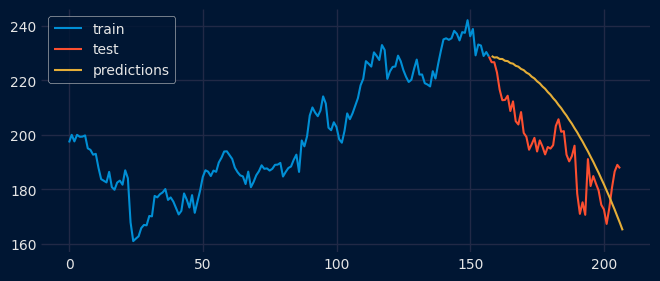

In [460]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['close'].plot(ax=ax, label='train')
data_test['close'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [461]:
# Prediction error
# ==============================================================================
error_mse = mean_absolute_error(
                y_true = data_test['close'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 13.598742440310327


In [462]:
# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(steps=50, alpha=0.05)
predictions.head(3)

,pred,lower_bound,upper_bound
158,228.918205,221.627040,236.209370
159,228.353539,217.927109,238.779969
160,228.446370,215.688151,241.204589


In [463]:
# Create and fit ForecasterSarimax with exogenous variables
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(2, 4, 4), seasonal_order=(0, 0, 0, 0), maxiter=200),
             )

forecaster.fit(
    y                 = data_train['close'], 
    exog              = data_train[['positive', 'neutral', 'negative']],
    suppress_warnings = True
)

# Predict with exog
# ==============================================================================
# Adjust the index of exog to start one step ahead of `last_window`
exog_adjusted = data_test[['positive', 'neutral', 'negative']].iloc[1:]

predictions = forecaster.predict(
                  steps = 49,
                  exog  = exog_adjusted
              )
predictions.head(3)

158    228.547523
159    228.496484
160    227.747489
Name: pred, dtype: float64

Train dates       : 0 --- 127  (n=128)
Last window dates : 127 --- 148  (n=22)
Test dates        : 148 --- 206  (n=59)


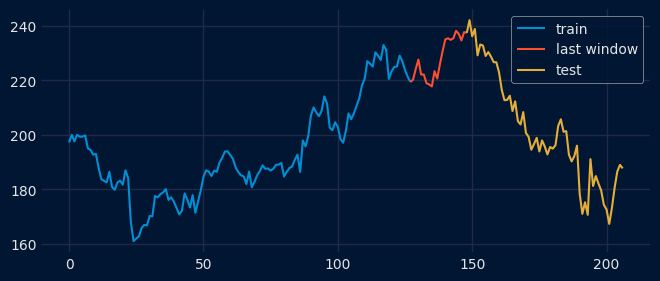

In [464]:
# Split data Train - Last window - Test
# ==============================================================================
end_train = 127
end_last_window = 148

print(
    f"Train dates       : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Last window dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_last_window].index.max()}  "
    f"(n={len(data.loc[end_train:end_last_window])})"
)
print(
    f"Test dates        : {data.loc[end_last_window:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_last_window:])})"
)
data_train       = data.loc[:end_train]
data_last_window = data.loc[end_train:end_last_window]
data_test        = data.loc[end_last_window:]

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['close'].plot(ax=ax, label='train')
data_last_window['close'].plot(ax=ax, label='last window')
data_test['close'].plot(ax=ax, label='test')
ax.legend();


In [465]:
# Create and fit ForecasterSarimax with exogenous variables
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(2, 4, 4), seasonal_order=(0, 0, 0, 0), maxiter=200),
             )

forecaster.fit(
    y                 = data_train['close'], 
    exog              = data_train[['positive', 'neutral', 'negative']],
    suppress_warnings = True
)

# Predict with exog and last window
# ==============================================================================
exog_adjusted = data_test[['positive', 'neutral', 'negative']].iloc[1:]
last_window_adjusted = data_last_window['close'].iloc[1:]
last_window_exog_adjusted = data_last_window[['positive', 'neutral', 'negative']].iloc[1:]

predictions = forecaster.predict(
                  steps            = 58,
                  exog             = exog_adjusted,
                  last_window      = last_window_adjusted,
                  last_window_exog = last_window_exog_adjusted
              )
predictions.head(20)

149    236.557513
150    237.584616
151    237.286960
152    236.104665
153    237.859387
154    238.889640
155    239.517097
156    239.045624
157    239.549705
158    239.535191
159    240.147662
160    239.411200
161    239.139030
162    238.421627
163    238.019032
164    239.959775
165    239.808528
166    239.789964
167    237.588788
168    239.087073
Name: pred, dtype: float64

In [466]:
# Prediction error
# ==============================================================================
error_mse = mean_absolute_error(
                y_true = data_test['close'].iloc[1:],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 35.1476151018927


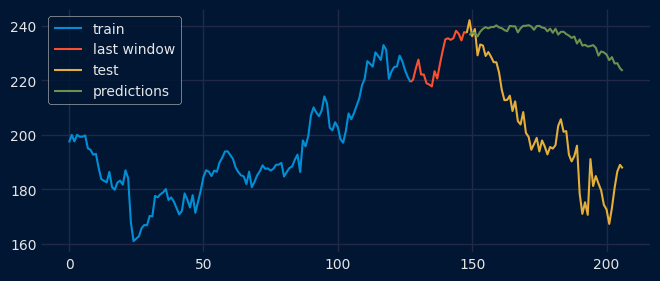

In [467]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['close'].plot(ax=ax, label='train')
data_last_window['close'].plot(ax=ax, label='last window')
data_test['close'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [468]:
# Feature importances
# ==============================================================================
forecaster.get_feature_importances()

,feature,importance
9,sigma2,12.915279
7,ma.L3,1.993237
0,positive,0.107660
4,ar.L2,0.039510
1,neutral,0.024645
6,ma.L2,-0.004005
3,ar.L1,-0.913105
8,ma.L4,-0.995976
2,negative,-1.101360
5,ma.L1,-1.993250


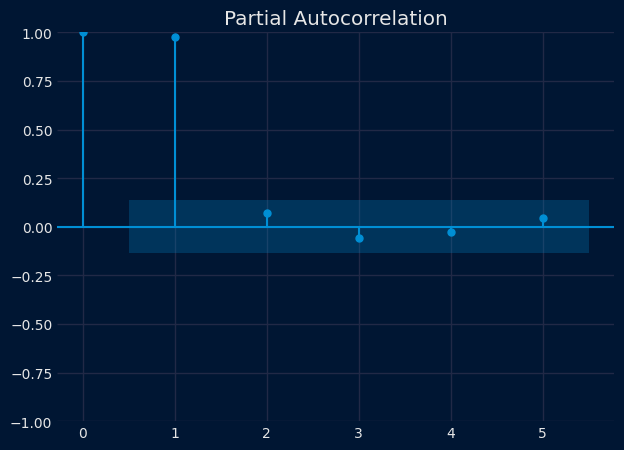

In [469]:
# Finding optimal p according to Adam <3
# p = 3
plot_pacf(data['close'], lags=5, method='ywm')
plt.show()

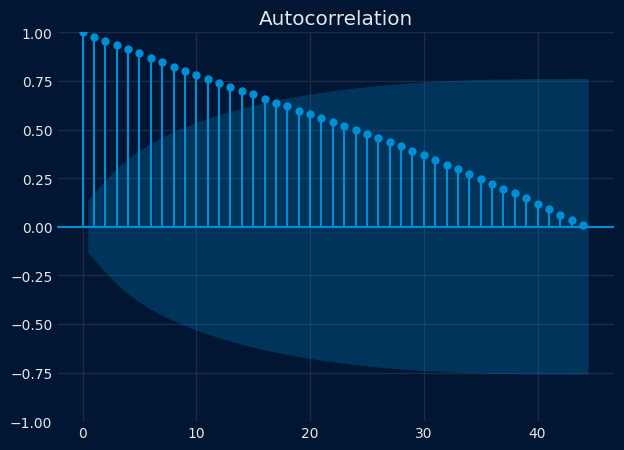

In [470]:
# Finding optimal q according to Adam <3
plot_acf(data['close'], lags=44)
plt.show()

In [471]:
# Finding optimal d according to Adam <3
# d = 4
result = adfuller(data['close'].diff(4).dropna())
print(result[1])

0.030548897740255317
